<a href="https://colab.research.google.com/github/b-richins92/Cancer_Prediction_10x/blob/main/GL_HVG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Testing highly variable genes**
Will use scanpy's method for detecting highly variable genes

1. Load in 30k dataset with original labels
2. Select highly variable genes using seurat_v3 method
3. Get lists of top 100, 200, 500, 1,000, 2,000, 5,000, or all genes. Also do the same for randomly selected genes
4. Do train/test split (for now, use default sklearn method with 5-fold cross-validation)
5. Plot all evaluation metrics for all approaches



In [1]:
# Install packages
!pip install scanpy[skmisc]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Set up paths to files
main_dir = '/content/drive/MyDrive/_Course materials/S6 M2-4 699 - Capstone/'
data_path = '/content/drive/MyDrive/_Course materials/S6 M2-4 699 - Capstone/Capstone - Shared folder/Data/'

# Change into correct directory for importing custom preprocessing function
%cd {main_dir}scripts/
%pwd

/content/drive/MyDrive/_Course materials/S6 M2-4 699 - Capstone/scripts


'/content/drive/MyDrive/_Course materials/S6 M2-4 699 - Capstone/scripts'

In [4]:
from main_functions import *
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from sklearn import set_config
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedGroupKFold, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, precision_score,\
                            balanced_accuracy_score, matthews_corrcoef, roc_auc_score, RocCurveDisplay, auc, average_precision_score, make_scorer

In [5]:
# Constants
random_state = 42
CV = 5

In [6]:
# Load in 30k dataset
adata_30k = create_adata(data_path + 'BRCA_EMTAB8107_expression.h5', data_path + 'BRCA_EMTAB8107_CellMetainfo_table.tsv')
adata_30k_df = adata_30k.to_df()

# Load in original labels and merge with TISCH counts
emtab_meta = pd.read_csv(data_path + 'EMTAB8107_2103-Breastcancer_metadata.csv.gz')
emtab_meta.set_index('Cell', inplace = True)
emtab_meta['orig_cancer_label'] = np.where(emtab_meta['CellType'] == 'Cancer', 1, 0)

# Merge original metadata with TISCH metadata
adata_30k.obs = pd.merge(adata_30k.obs, emtab_meta['orig_cancer_label'], left_index = True, right_index = True, how = 'inner')
print(f'Original # cells: {len(emtab_meta)}, TISCH # cells: {adata_30k.n_obs}, merged # cells: {len(adata_30k.obs)}')
display(adata_30k.obs.head())

Number of cells: 33043
Number of features: 22835
564.07 MB
Original # cells: 44024, TISCH # cells: 33043, merged # cells: 33043


,cancer_label,cell_type_malignancy,cell_type_major,cell_type_minor,Patient,Sample,patient_id,orig_cancer_label
sc5rJUQ024_AAACCTGGTCTCCACT,0,Immune cells,B,B,P41,Sample41,sc5rJUQ024,1
sc5rJUQ024_AAAGATGCAGCGAACA,0,Immune cells,B,B,P41,Sample41,sc5rJUQ024,0
sc5rJUQ024_AACCATGTCCTAGTGA,0,Immune cells,B,B,P41,Sample41,sc5rJUQ024,0
sc5rJUQ024_AACTCAGGTGTGACCC,0,Immune cells,B,B,P41,Sample41,sc5rJUQ024,0
sc5rJUQ024_AAGACCTGTCCGTGAC,0,Immune cells,B,B,P41,Sample41,sc5rJUQ024,0


In [7]:
# Identify highly variable genes using scanpy's seurat_v3 method (calculate z-normalized dispersion for genes binned by expression level)
# Set n_top_genes to total number of genes. Will then subset features
adata_30k_hvg = sc.pp.highly_variable_genes(adata_30k, flavor='seurat_v3', n_top_genes=adata_30k.n_vars, inplace = False)
adata_30k_hvg = adata_30k_hvg.sort_values(by = 'highly_variable_rank')
print(adata_30k_hvg.shape)
print(adata_30k.n_vars)
print(len(adata_30k_hvg[adata_30k_hvg['highly_variable'] == True]))
display(adata_30k_hvg.head())
display(adata_30k_hvg.tail())

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


(22835, 6)
22835
22835


,means,variances,gene_name,highly_variable_rank,variances_norm,highly_variable
SMAD7,0.887474,3.308776,SMAD7,0.0,4.553986,True
CARD10,0.009493,0.044098,CARD10,1.0,4.182368,True
IGLV2-18,0.827848,2.843900,IGLV2-18,2.0,4.063268,True
CTD-2516F10.2,0.392256,1.559758,CTD-2516F10.2,3.0,3.865937,True
CDS1,0.732056,2.457680,CDS1,4.0,3.774669,True


,means,variances,gene_name,highly_variable_rank,variances_norm,highly_variable
TLCD1,0.000387,0.000190,TLCD1,22830.0,0.503812,True
TMEM134,0.000210,0.000083,TMEM134,22831.0,0.493307,True
ZNF711,0.000288,0.000128,ZNF711,22832.0,0.492238,True
CPA3,0.000267,0.000115,CPA3,22833.0,0.488744,True
RP11-103H7.5,0.000256,0.000104,RP11-103H7.5,22834.0,0.467886,True


In [8]:
# Choose random features - random order of all features, then choose subset for top features
rng = np.random.default_rng(random_state)
random_features = rng.choice(adata_30k.var_names, size = adata_30k.n_vars, replace=False)
print(len(random_features))

22835


In [9]:
# Train/test split using standard sklearn method - train/test split by patient

# Defining variables
num_features = [20, 50, 100, 200, 500, 1000, 2000, 5000, 10000] #, adata_30k.n_vars

hvg_features = adata_30k_hvg.index
X = adata_30k_df
y = adata_30k.obs['orig_cancer_label']
groups = adata_30k.obs['Patient']
metrics_dict = {'accuracy': 'accuracy', 'balanced_accuracy': 'balanced_accuracy',
                'f1': 'f1', 'recall': 'recall', 'precision': 'precision',
                'average_precision': 'average_precision', 'roc_auc': 'roc_auc',
                'matthews_corrcoef': make_scorer(matthews_corrcoef)}

# Use dictionary to store folds
results_dict = {}
results_df = pd.DataFrame()

# Set up model - SVM
classifier = LinearSVC(random_state=random_state)

# 5-fold cross-validation (stratified, divided by patients) for SVM
sgkf = StratifiedGroupKFold(n_splits=5, shuffle = True, random_state = random_state)

# for i, (train_index, test_index) in enumerate(sgkf.split(X, y, groups)):
#     print(f"Fold {i}:")
#     print(f"  Train: group={groups[train_index].unique()}")
#     print(f"  Test:  group={groups[test_index].unique()}")

for curr_num_feat in num_features:
  print(f'curr_num_feat: {curr_num_feat}')

  # Get results for top N highly variable genes
  curr_results_hvg = cross_validate(classifier, X[hvg_features[:curr_num_feat]], y, groups = groups, scoring = metrics_dict,
                 cv = sgkf, return_train_score = True)
  curr_results_hvg['feature_type'] = 'hvg'
  curr_results_hvg['num_features'] = curr_num_feat
  results_df = pd.concat([results_df, pd.DataFrame.from_dict(curr_results_hvg)], ignore_index=True)

  # Get results for top N random genes
  curr_results_rand = cross_validate(classifier, X[random_features[:curr_num_feat]], y, groups = groups, scoring = metrics_dict,
                 cv = sgkf, return_train_score = True)
  curr_results_rand['feature_type'] = 'rand'
  curr_results_rand['num_features'] = curr_num_feat
  results_df = pd.concat([results_df, pd.DataFrame.from_dict(curr_results_rand)], ignore_index=True)

  print(f'results_df.shape: {results_df.shape}')

results_df.to_csv(main_dir + 'scripts/results_df.csv')

curr_num_feat: 20
results_df.shape: (10, 20)
curr_num_feat: 50
results_df.shape: (20, 20)
curr_num_feat: 100
results_df.shape: (30, 20)
curr_num_feat: 200
results_df.shape: (40, 20)
curr_num_feat: 500
results_df.shape: (50, 20)
curr_num_feat: 1000
results_df.shape: (60, 20)
curr_num_feat: 2000
results_df.shape: (70, 20)
curr_num_feat: 5000
results_df.shape: (80, 20)
curr_num_feat: 10000
results_df.shape: (90, 20)


,feature_type,num_features,metric,score
0,hvg,20,fit_time,0.096863
1,hvg,20,fit_time,0.126923
2,hvg,20,fit_time,0.123142
3,hvg,20,fit_time,0.060867
4,hvg,20,fit_time,0.132740


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a grad

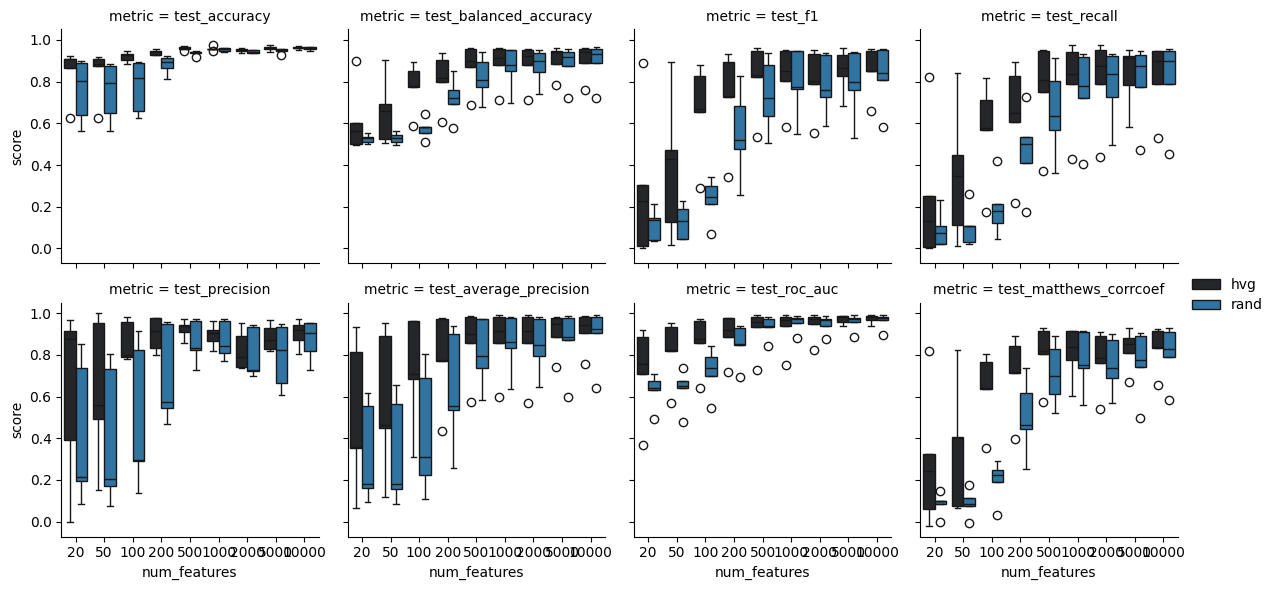

In [24]:
# Plot metrics vs number of features
# Compare for HVG vs random for test metrics, averaged across all 5 folds

# Convert to tall df - combine all metrics into 1 column
results_df_tall = results_df.melt(id_vars=['feature_type', 'num_features'], var_name='metric', value_name='score')
display(results_df_tall.head())

# Add additional column for train or test, or just keep rows with 'test_' in metric name
results_sub = results_df_tall[results_df_tall['metric'].str.contains('test_')]

# Plot metric score versus number of features. Facet by metric. Color by feature type
g = sns.FacetGrid(results_sub, col="metric", col_wrap=4, sharey=True)
#g.map(sns.scatterplot, "num_features", "score")
g.map(sns.boxplot, "num_features", "score", "feature_type") #, data = results_sub
g.add_legend()
